Install Dependencies
----------

In [1]:
!pip install cmake 'gym[atari]' scipy

In [2]:
!pip install torch

Import Dependencies
----------

In [0]:
import numpy as np
from IPython.display import clear_output
from time import sleep
import random
import gym

In [0]:
from collections import namedtuple, deque
from itertools import count
import math
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import time
import scipy.sparse.csgraph

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

## Taxi Gym Environment

In [6]:
env = gym.make("Taxi-v2").env

env.render()

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



- The filled square represents the taxi, which is yellow without a passenger and green with a passenger.
- The pipe ("|") represents a wall which the taxi cannot cross.
- R, G, Y, B are the possible pickup and destination locations. The blue letter represents the current passenger pick-up location, and the purple letter is the current destination.

In [7]:
env.reset() # reset environment to a new, random state
env.render()

print("Action Space {}".format(env.action_space))
print("State Space {}".format(env.observation_space))

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

Action Space Discrete(6)
State Space Discrete(500)


In [8]:
state = env.encode(3, 1, 2, 0) # (taxi row, taxi column, passenger index, destination index)
print("State:", state)

env.s = state
env.render()

State: 328
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



When the taxi contains the passenger, passenger index is 4

In [9]:
state = env.encode(3, 1, 4, 0) # (taxi row, taxi column, passenger index, destination index)
print("State:", state)

env.s = state
env.render()

State: 336
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| |_: | : |
|Y| : |B: |
+---------+



### Solve an episode yourself: 
Use the following actions:
- 0 = south
- 1 = north
- 2 = east
- 3 = west
- 4 = pickup
- 5 = dropoff

In [10]:
env.s = 328
env.render()

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [11]:
# Use Ctrl+Enter to take an action
env.step(1)
env.render()

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)


In [12]:
env.step(3)
env.render()

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)


In [13]:
env.step(0)
env.render()

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)


In [14]:
env.step(5)
env.render()

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)


In [15]:
env.s = 328  # set environment to illustration's state

epochs = 0
penalties, reward = 0, 0

frames = [] # for animation

done = False

while not done:
    action = env.action_space.sample()
    state, reward, done, info = env.step(action)

    if reward == -10:
        penalties += 1
    
    # Put each rendered frame into dict for animation
    frames.append({
        'frame': env.render(mode='ansi'),
        'state': state,
        'action': action,
        'reward': reward
        }
    )

    epochs += 1
    
    
print("Timesteps taken: {}".format(epochs))
print("Penalties incurred: {}".format(penalties))

Timesteps taken: 256
Penalties incurred: 58


In [16]:
def print_frames(frames):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'].getvalue())
        print(f"Timestep: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        sleep(.1)
        
print_frames(frames)

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 256
State: 0
Action: 5
Reward: 20


# Q-Learning
Our environment is deterministic, so all equations presented here are
also formulated deterministically for the sake of simplicity. In the
reinforcement learning literature, they would also contain expectations
over stochastic transitions in the environment.

Our aim will be to train a policy that tries to maximize the discounted,
cumulative reward
$R_{t_0} = \sum_{t=t_0}^{\infty} \gamma^{t - t_0} r_t$, where
$R_{t_0}$ is also known as the *return*. The discount,
$\gamma$, should be a constant between $0$ and $1$
that ensures the sum converges. It makes rewards from the uncertain far
future less important for our agent than the ones in the near future
that it can be fairly confident about.

The main idea behind Q-learning is that if we had a function
$Q^*: State \times Action \rightarrow \mathbb{R}$, that could tell
us what our return would be, if we were to take an action in a given
state, then we could easily construct a policy that maximizes our
rewards:

\begin{align}\pi^*(s) = \arg\!\max_a \ Q^*(s, a)\end{align}

However, we don't know everything about the world, so we don't have
access to $Q^*$.

# Tabular Q-Learning

We use a table to represent $Q*$. Q-values are initialized to an arbitrary value, and as the agent exposes itself to the environment and receives different rewards by executing different actions, the Q-values are updated using the equation:

$Q (s_t, a_t)←(1−α)*Q(s_t,a_t) + α*(r_t + γ*max_a Q(s_{t+1}, a))$

Where:

- $α$ (alpha) is the learning rate ($0<α≤1$) - Just like in supervised learning settings, α is the extent to which our Q-values are being updated in every iteration.

- $γ$ (gamma) is the discount factor ($0≤γ≤1$) - determines how much importance we want to give to future rewards. A high value for the discount factor (close to 1) captures the long-term effective award, whereas, a discount factor of 0 makes our agent consider only immediate reward, hence making it greedy.

Tabular Q-Learning steps
- Initialize the Q-table by all zeros.
- Start exploring actions: For each state, select any one among all possible actions for the current state (S).
- Travel to the next state (S') as a result of that action (a).
- For all possible actions from the state (S') select the one with the highest Q-value.
- Update Q-table values using the equation.
- Set the next state as the current state.
- If goal state is reached, then end and repeat the process.

Exploiting learned values:
After enough random exploration of actions, the Q-values tend to converge serving our agent as an action-value function which it can exploit to pick the most optimal action from a given state.

There's a tradeoff between exploration (choosing a random action) and exploitation (choosing actions based on already learned Q-values). We want to prevent the action from always taking the same route, and possibly overfitting, so we'll be introducing another parameter called $ϵ$ "epsilon" to cater to this during training.

Instead of just selecting the best learned Q-value action, we'll sometimes favor exploring the action space further. Lower epsilon value results in episodes with more penalties (on average) which is obvious because we are exploring and making random decisions.

In [0]:
q_table = np.zeros([env.observation_space.n, env.action_space.n])

In [46]:
%%time
"""Training the agent"""

max_episode_length = 500
num_training_episodes = 1000

# Hyperparameters
alpha = 0.1
gamma = 0.6
epsilon = 0.1

# For plotting metrics
all_epochs = []
all_penalties = []

for i in range(1, num_training_episodes+1):
    state = env.reset()

    epochs, penalties, reward, = 0, 0, 0
    done = False
    
    for _ in range(max_episode_length):
        
        ### Write code to sample action
        if random.uniform(0, 1) < epsilon:
            ## Explore
            action = env.action_space.sample()
        else:
            ## Exploit
            action = np.argmax(q_table[state])

        reward += get_shaped_reward(env.decode(prev_state.numpy()), env.decode(state)) # after adding reward shaping, the performance is still not good. Because it needs to share new info in each iteration stage
        # need to reach out of the states and bootstrap
        next_state, reward, done, info = env.step(action)
        
        ### Write Q-Learning update equations
        old_value = q_table[state, action]
        new_value = (1 - alpha) * old_value + alpha*(reward + gamma * np.max(q_table[next_state]))
        q_table[state, action] = new_value

        if reward == -10:
            penalties += 1

        state = next_state
        epochs += 1
        
        if done:
            break
        
    if i % 100 == 0:
        clear_output(wait=True)
        print(f"Episode: {i}")

print("Training finished.\n")

Episode: 1000
Training finished.

CPU times: user 6.5 s, sys: 41 ms, total: 6.54 s
Wall time: 6.51 s


In [47]:
q_table[328]

array([-2.32350668, -2.32069885, -2.32405342, -2.32270488, -5.71311619,
       -6.33258433])

In [48]:
"""Evaluate agent's performance after Q-learning"""
max_episode_length = 500
total_epochs, total_penalties, total_reward = 0., 0., 0.
episodes = 100

for _ in range(episodes):
    state = env.reset()
    epochs, penalties, reward = 0, 0, 0
    
    done = False
    eps_reward = 0.
    
    for _ in range(max_episode_length):
        action = np.argmax(q_table[state])
        state, reward, done, info = env.step(action)
        
        eps_reward += reward

        if reward == -10:
            penalties += 1

        epochs += 1
        
        if done:
            break
        
    
    total_reward += eps_reward
    total_penalties += penalties
    total_epochs += epochs

print(f"Results after {episodes} episodes:")
print(f"Average timesteps per episode: {total_epochs / episodes}")
print(f"Average reward per episode: {total_reward / episodes}")
print(f"Average penalties per episode: {total_penalties / episodes}")

Results after 100 episodes:
Average timesteps per episode: 348.09
Average reward per episode: -341.58
Average penalties per episode: 0.0


In [0]:
# small action space, works well; but when actions are more, there are more info needed to be shared among the states. So we want to use deep-Q learning
# policy and off-policy, policy gradients could help. For unpolicy, give examples and then estimate easily

# Deep Q-Learning
Now, we train a neural network to resemble $Q^*$.

For our training update rule, we'll use a fact that every $Q$
function for some policy obeys the Bellman equation:

\begin{align}Q^{\pi}(s, a) = r + \gamma Q^{\pi}(s', \pi(s'))\end{align}

The difference between the two sides of the equality is known as the
temporal difference error, $\delta$:

\begin{align}\delta = Q(s, a) - (r + \gamma \max_a Q(s', a))\end{align}

To minimise this error, we will use the [Huber Loss](https://en.wikipedia.org/wiki/Huber_loss).
The Huber loss acts
like the mean squared error when the error is small, but like the mean
absolute error when the error is large - this makes it more robust to
outliers when the estimates of $Q$ are very noisy. We calculate
this over a batch of transitions, $B$, sampled from the replay
memory:

\begin{align}\mathcal{L} = \frac{1}{|B|}\sum_{(s, a, s', r) \ \in \ B} \mathcal{L}(\delta)\end{align}

\begin{align}\text{where} \quad \mathcal{L}(\delta) = \begin{cases}
     \frac{1}{2}{\delta^2}  & \text{for } |\delta| \le 1, \\
     |\delta| - \frac{1}{2} & \text{otherwise.}
   \end{cases}\end{align}


#### Q-network
Our model will be a neural network that takes in the state as input and outputs the Q-value for each action in that state. In effect, the network is trying to predict the *expected return* of
taking each action given the current input.

In [0]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [0]:
class DQN(nn.Module):

    def __init__(self, input_size, output_size):
        super(DQN, self).__init__()
        self.embedding = nn.Embedding(input_size, 64) # first layer, convert into 64 vector
        self.linear1 = nn.Linear(64, 64) # another layer
        self.linear2 = nn.Linear(64, output_size) # last output layer

    def forward(self, x):
        x = nn.ReLU()(self.embedding(x))
        x = nn.ReLU()(self.linear1(x))
        x = self.linear2(x)
        return x

In [0]:
steps_done = 0

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(env.action_space.n)]], dtype=torch.long)


def plot(stat, averaging_size):
    durations_t = torch.tensor(stat, dtype=torch.float)
    if len(durations_t) >= averaging_size:
        means = durations_t.unfold(0, averaging_size, 1).mean(1).view(-1)
        plt.figure(2)
        plt.clf()
        plt.title('Training...')
        plt.xlabel('Episode')
        plt.ylabel('Duration')
        plt.ylim(-10, 510)
        plt.plot(means.numpy())

    plt.pause(0.00001)

In [0]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), dtype=torch.uint8)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch)
    state_action_values = state_action_values.gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    next_state_values = next_state_values.detach()
    
    # Compute the expected Q values
    expected_state_action_values = (next_state_values*GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()
    return loss.item()

Episode: 99, Mean Reward: -35.670, Mean Loss: 0.000, Success Rate: 0.000 (100)


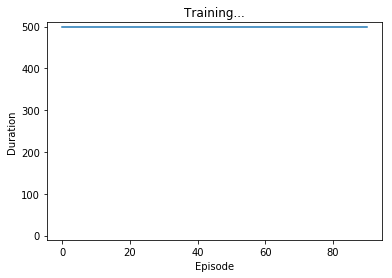

In [28]:
num_episodes = 100
max_episode_length = 500

BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 1.0
EPS_END = 0.05
EPS_DECAY = 5000
TARGET_UPDATE = 10000
LEARNING_RATE = 0.005

policy_net = DQN(env.observation_space.n, env.action_space.n)
target_net = DQN(env.observation_space.n, env.action_space.n)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters(), lr=LEARNING_RATE)
memory = ReplayMemory(10000)

steps_done = 0
episode_durations = []

losses = deque(maxlen=10000)
eps_rewards = deque(maxlen=100)
successes = deque(maxlen=100)

for i_episode in range(num_episodes):
    # Initialize the environment and state
    state = env.reset()
    state = torch.tensor([state])
    eps_reward = 0
    for t in range(max_episode_length):
        # Select and perform an action
        prev_state = state
        action = select_action(state)
        state, reward, done, _ = env.step(action.item())
#         reward += get_shaped_reward(env.decode(prev_state.numpy()), env.decode(state))

        #Reward Normalization
        reward /= 20.0 
        
        state = torch.tensor([state])
        eps_reward += reward
        reward = torch.tensor([reward]).float()

        if not done:
            next_state = state 
        else:
            next_state = None

        # Store the transition in memory
        memory.push(prev_state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        loss = optimize_model()
        if loss is not None:
            losses.append(loss)
        if done:
            break
            
    if reward > 0.75:
        successes.append(1.)
    else:
        successes.append(0.)
    
    eps_rewards.append(eps_reward)
    clear_output(wait=True)
    print("Episode: {}, Mean Reward: {:.3f}, Mean Loss: {:.3f}, Success Rate: {:.3f} ({:d})".format(
            i_episode, np.mean(eps_rewards), np.mean(losses), np.mean(successes), len(successes)))
    
    episode_durations.append(t + 1)
    plot(episode_durations, 10)
    time.sleep(0.0001)
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

In [0]:
# the model will not perform well, it needs much much more data

## Reward Shaping

In [0]:
# find the shortest path

def compute_full_distances_fast(grid):
    """
    Input:
        `grid`: maze plan of shape (m, n)
    Output:
        `distances`: distances between each position in the grid (m, n, m, n)
    """
    # compute valid positions
    m, n = grid.shape
    distances = np.zeros((m, n, m, n), dtype=np.int32) + m * n
    valid = [(i, j) for i in range(m) for j in range(n) if grid[i, j] == 0]

    # initialize distances: 0 to self, 1 to adjacent squares
    for i1, j1 in valid:
        distances[i1, j1, i1, j1] = 0  # distance to self
        for i2, j2 in [(i1 - 1, j1), (i1 + 1, j1), (i1, j1 - 1), (i1, j1 + 1)]:
            if 0 <= i2 < m and 0 <= j2 < n and grid[i2, j2] == 0:
                distances[i1, j1, i2, j2] = 1  # distance to neighbors

    distances = scipy.sparse.csgraph.floyd_warshall(distances.reshape(m * n, m * n), directed=False)
    distances = distances.reshape((m, n, m, n)).astype(np.int32)

    return distances

In [0]:
grid = np.zeros((11, 11))
grid[0,:] = 1
grid[-1,:] = 1
grid[:,0] = 1
grid[:,-1] = 1
grid[6:,2] = 1
grid[6:,6] = 1
grid[:3,4] = 1

distances = compute_full_distances_fast(grid)

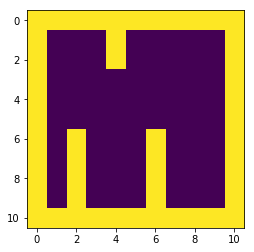

In [31]:
plt.imshow(grid)

In [0]:
distances[distances > 40] = 0

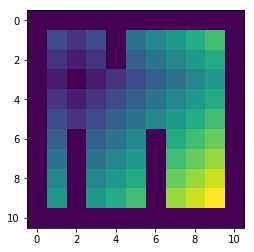

In [39]:
plt.imshow(distances[3,2])

In [0]:
def get_shaped_reward(prev_state, state):
    if prev_state is None:
        return 0
    s = []
    for i in prev_state:
        s.append(i)
    x1, y1 = s[0], s[1]
    if s[2] == 4:
        goal = s[3]
    else:
        goal = s[2]
        
    ps = []
    for i in state:
        ps.append(i)
    x2, y2 = ps[0], ps[1]
    
    if goal == 0:
        gx, gy = 0, 0
    elif goal == 1:
        gx, gy = 0, 4
    elif goal == 2:
        gx, gy = 4, 0
    elif goal == 3:
        gx, gy = 4, 3
    
    gx = 2*gx + 1
    gy = 2*gy + 1
    x1 = 2*x1 + 1
    x2 = 2*x2 + 1
    y1 = 2*y1 + 1
    y2 = 2*y2 + 1
    
    prev_dist = distances[gx,gy][x1,y1]
    dist = distances[gx,gy][x2,y2]
    
    if prev_dist > dist:
        return 6.
    else:
        return -4.

Episode: 99, Mean Reward: -12.076, Mean Loss: 0.003, Success Rate: 0.970 (100)


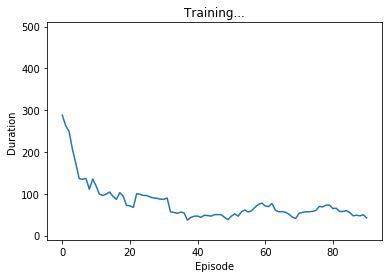

In [42]:
num_episodes = 100
max_episode_length = 500
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 1.0
EPS_END = 0.05
EPS_DECAY = 5000
TARGET_UPDATE = 10000
LEARNING_RATE = 0.005

policy_net = DQN(env.observation_space.n, env.action_space.n)
target_net = DQN(env.observation_space.n, env.action_space.n)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters(), lr=LEARNING_RATE)
memory = ReplayMemory(10000)

steps_done = 0
episode_durations = []

losses = deque(maxlen=10000)
eps_rewards = deque(maxlen=100)
successes = deque(maxlen=100)

for i_episode in range(num_episodes):
    # Initialize the environment and state
    state = env.reset()
    state = torch.tensor([state])
    eps_reward = 0
    for t in range(max_episode_length):
        # Select and perform an action
        prev_state = state
        action = select_action(state)
        state, reward, done, _ = env.step(action.item())
        reward += get_shaped_reward(env.decode(prev_state.numpy()), env.decode(state))
        reward /= 20.0
        state = torch.tensor([state])
        eps_reward += reward
        reward = torch.tensor([reward]).float()

        if not done:
            next_state = state 
        else:
            next_state = None

        # Store the transition in memory
        memory.push(prev_state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        loss = optimize_model()
        if loss is not None:
            losses.append(loss)
        if done:
            break
            
    if reward > 0.75:
        successes.append(1.)
    else:
        successes.append(0.)
    
    eps_rewards.append(eps_reward)
    clear_output(wait=True)
    print("Episode: {}, Mean Reward: {:.3f}, Mean Loss: {:.3f}, Success Rate: {:.3f} ({:d})".format(
            i_episode, np.mean(eps_rewards), np.mean(losses), np.mean(successes), len(successes)))
    
    episode_durations.append(t + 1)
    plot(episode_durations, 10)
    time.sleep(0.0001)
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())